In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
from scipy.signal import convolve2d as conv2
from numpy import histogram as hist

import math
import numpy as np
from scipy import signal


sys.path.append('..')
%load_ext autoreload
%autoreload 2

Welcome to the first assignment notebook! Please remember that there is also another notebook together with this one :)


In this notebook, you will first familiarise yourself with basic image filtering routines. In the second part, you will develop a simple image querying system that accepts a query image as input and then finds a set of similar images in the database. To compare images, you will implement some simple histogram-based distance functions and evaluate their performance in combination with different image representations. The first parts are already implemented for you to familiarize yourself with the notebook.

We first implement a function that computes the values of a 1-D Gaussian for a given variance $\sigma^2$. The method should also give a vector of values on which the Gaussian filter is defined: integer values on the interval $[-3\sigma,3\sigma]$.
  
\begin{equation}
  G(x; \sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{x^2}{2\sigma^2}).
\end{equation}

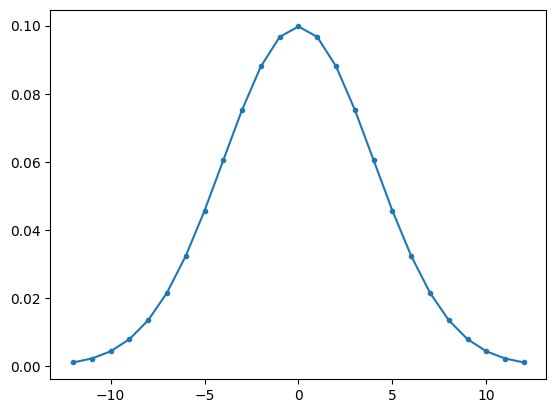

In [3]:
def gauss(sigma):
    x = np.arange(math.ceil(-3*sigma), math.floor(3*sigma)+1)
    Gx = 1/(sigma * math.sqrt(2*math.pi)) * np.exp(-np.square(x)/(2*sigma**2))
    return Gx, x

sigma = 4.0
[gx, x] = gauss(sigma)

plt.figure()
plt.plot(x, gx, '.-')
plt.show()

We now implement a 2D Gaussian filter. The function should take an image as an input and return the result of the convolution of this image a with 2D Gaussian kernel of given variance $\sigma^2$. See **Figure 1** for an illustration of Gaussian filtering. We can take advantage of the `convolve2d` function from the `scipy` library.

*Hint: We use the fact that the 2D Gaussian filter is separable to speed up computations.*

**Figure 1: Left: Original image. Right: Image after applying a Gaussian filter with $\sigma = 4.0$.**

<img src="./data/exercise-1/not_smooth.png" width="300" align=left>
<img src="./data/exercise-1/smooth.png" width="300" align=left>

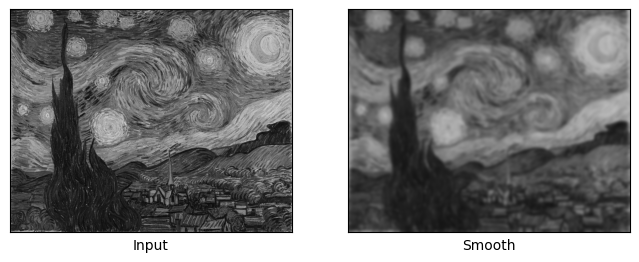

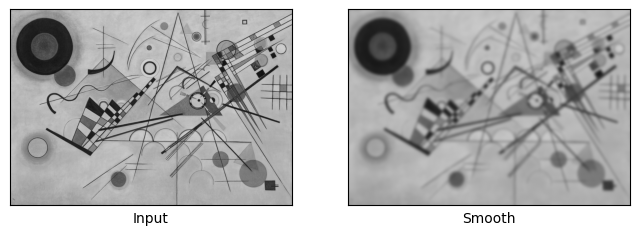

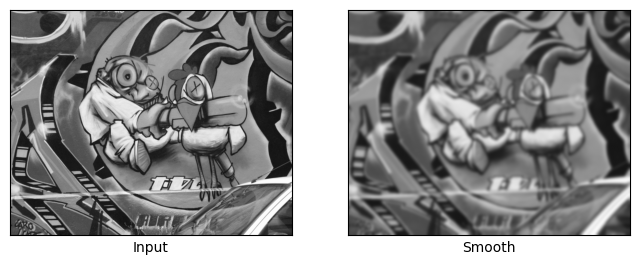

In [4]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def gaussianfilter(img, sigma):    
    kernel = np.expand_dims(gauss(sigma)[0], 0)
    
    # Note that we are operating on images,
    # hence we apply both the filter and its transpose!
    outimage = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    outimage = signal.convolve2d(outimage, kernel.T, boundary='symm', mode='same')
    
    return outimage

def filter_image(image_path):
    img = rgb2gray(np.array(Image.open(image_path)))
    smooth_img = gaussianfilter(img, sigma)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[0].set_xlabel('Input')
    axes[1].imshow(smooth_img, cmap='gray', vmin=0, vmax=255)
    axes[1].set_xlabel('Smooth')
    
    for ax in axes: # Remove the ugly ticks
        ax.set_xticks([]); ax.set_yticks([])
        
    plt.show()
    
filter_image('./data/exercise-1/night.png')
filter_image('./data/exercise-1/kand.png')
filter_image('./data/exercise-1/graf.png')

We now implement a function `gaussdx` for creating a Gaussian derivative filter in 1D according to the following equation:

\begin{equation}
    \frac{d}{dx}G = \frac{d}{dx}\frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{x^2}{2\sigma^2})\\
    = -\frac{1}{\sqrt{2\pi}\sigma^3}x \exp(-\frac{x^2}{2\sigma^2})
\end{equation}

The effect of applying a filter can be studied by observing its
so-called $\textit{impulse response}$. For this, create a test image
in which only the central pixel has a non-zero value:

```
  imgImp = np.zeros((27,27))
  imgImp[14,14] = 1.0
```

Now, create the following 1D filter kernels $G$ and $D$.

```
  sigma = 5.0
  G = gauss(sigma)
  D = gaussdx(sigma)
```

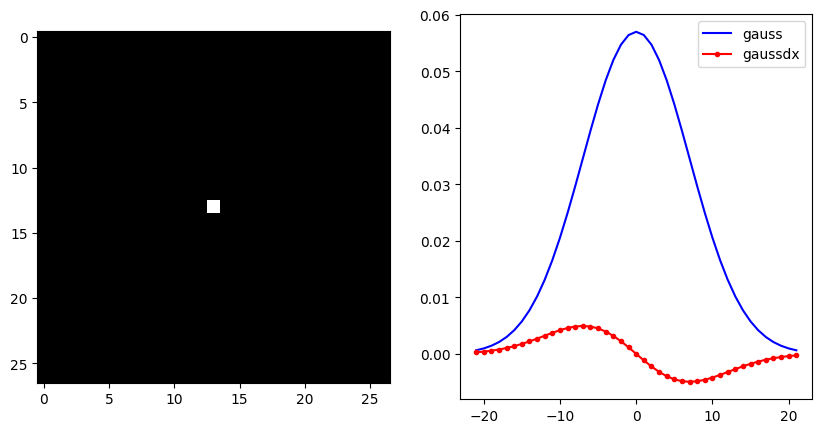

In [5]:
def gaussdx(sigma):
    ########## TODO #################################
    x = np.arange(np.ceil(-3 * sigma), np.floor(3 * sigma) + 1)
    D = -1 / (math.sqrt(2 * math.pi) * sigma ** 3) * x * np.exp(-1 * np.square(x) / (2 * sigma ** 2))
    #################################################
    return D, x

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# The image (i.e signal) on the left
img = np.zeros([27,27])
img[13, 13] = 1.0
axes[0].imshow(img, cmap='gray')

# The filters  on the right
sigma = 7.0
[G, x] = gauss(sigma)
[D, x] = gaussdx(sigma)
axes[1].plot(x, G, 'b-')
axes[1].plot(x, D, 'r.-')
axes[1].legend( ('gauss', 'gaussdx'))
plt.show()

We now use the functions `gauss` and `gaussdx` in order to implement a function `gaussderiv` that returns the 2D Gaussian derivatives of an input image in x and y direction. Try the function on the three test images.

<Figure size 640x480 with 0 Axes>

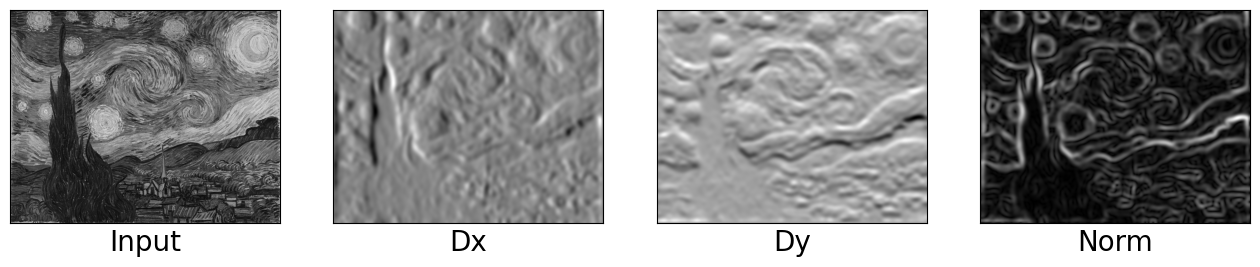

<Figure size 640x480 with 0 Axes>

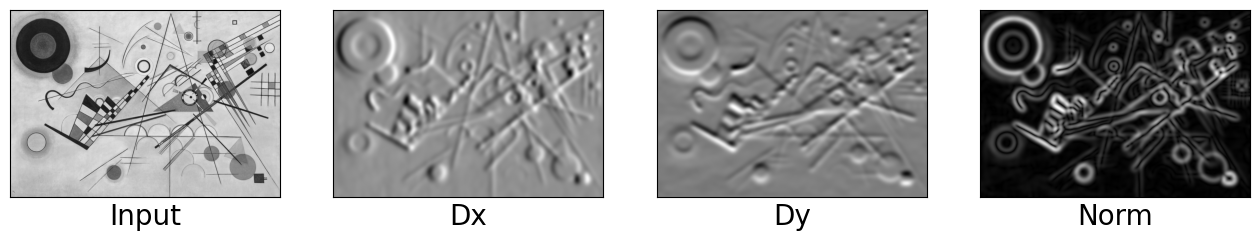

<Figure size 640x480 with 0 Axes>

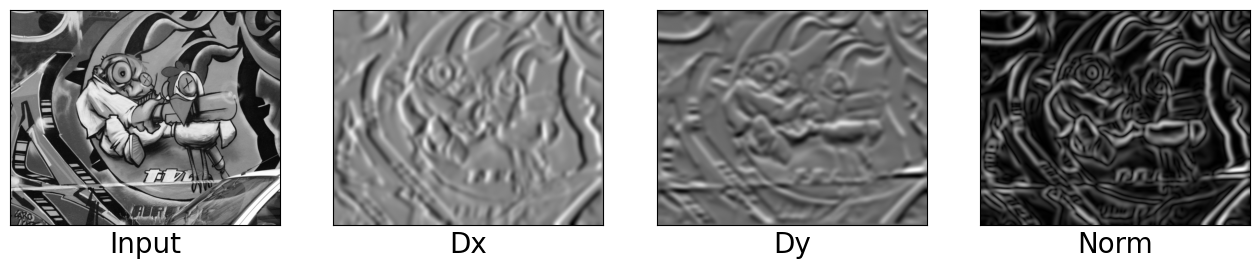

In [6]:
def gaussderiv(img, sigma):
    G = gauss(sigma)[0].reshape(-1, 1)
    D = gaussdx(sigma)[0].reshape(-1, 1)
    kernel = np.matmul(D, G.T).T
    
    ######## TODO ##################################
    # Apply the kernel and get the derivative image for both X and Y direction.
    # You can take hint from the above.
    # outimage = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    imgDx = signal.convolve2d(img, kernel, boundary = 'symm', mode = 'same')
    imgDy = signal.convolve2d(img, kernel.T, boundary = 'symm', mode = 'same')
    ################################################
    return imgDx, imgDy

### The following code is used for evaluation.
def run_one_img(image_path):
    img_c = np.array(Image.open(image_path)).astype('double')
    img = rgb2gray(img_c)
    [imgDx, imgDy] = gaussderiv(img, 7.0)

    plt.figure()
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_xlabel('Input', fontsize=20)

    axes[1].imshow(imgDx, cmap='gray')
    axes[1].set_xlabel('Dx', fontsize=20)

    axes[2].imshow(imgDy, cmap='gray')
    axes[2].set_xlabel('Dy', fontsize=20)

    imgmag = np.sqrt(imgDx**2 + imgDy**2)
    axes[3].imshow(imgmag, cmap='gray')
    axes[3].set_xlabel('Norm', fontsize=20)

    for ax in axes:
        ax.set_xticks([]); ax.set_yticks([])
    
    plt.show()
    
run_one_img('./data/exercise-1/night.png')
run_one_img('./data/exercise-1/kand.png')
run_one_img('./data/exercise-1/graf.png')

### Question 1: Image Representations and Histogram Distances (10 points)

**Q1.1** Implement a function `normalized_histogram`, which takes a gray-value image as input and returns a normalized histogram of pixel intensities. Compare your implementation with the built-in Python function `numpy.histogram`. Your histograms and the histograms computed with Python should be approximately the same, except for the overall scale, which will be different since `numpy.histogram` does not normalize its output.

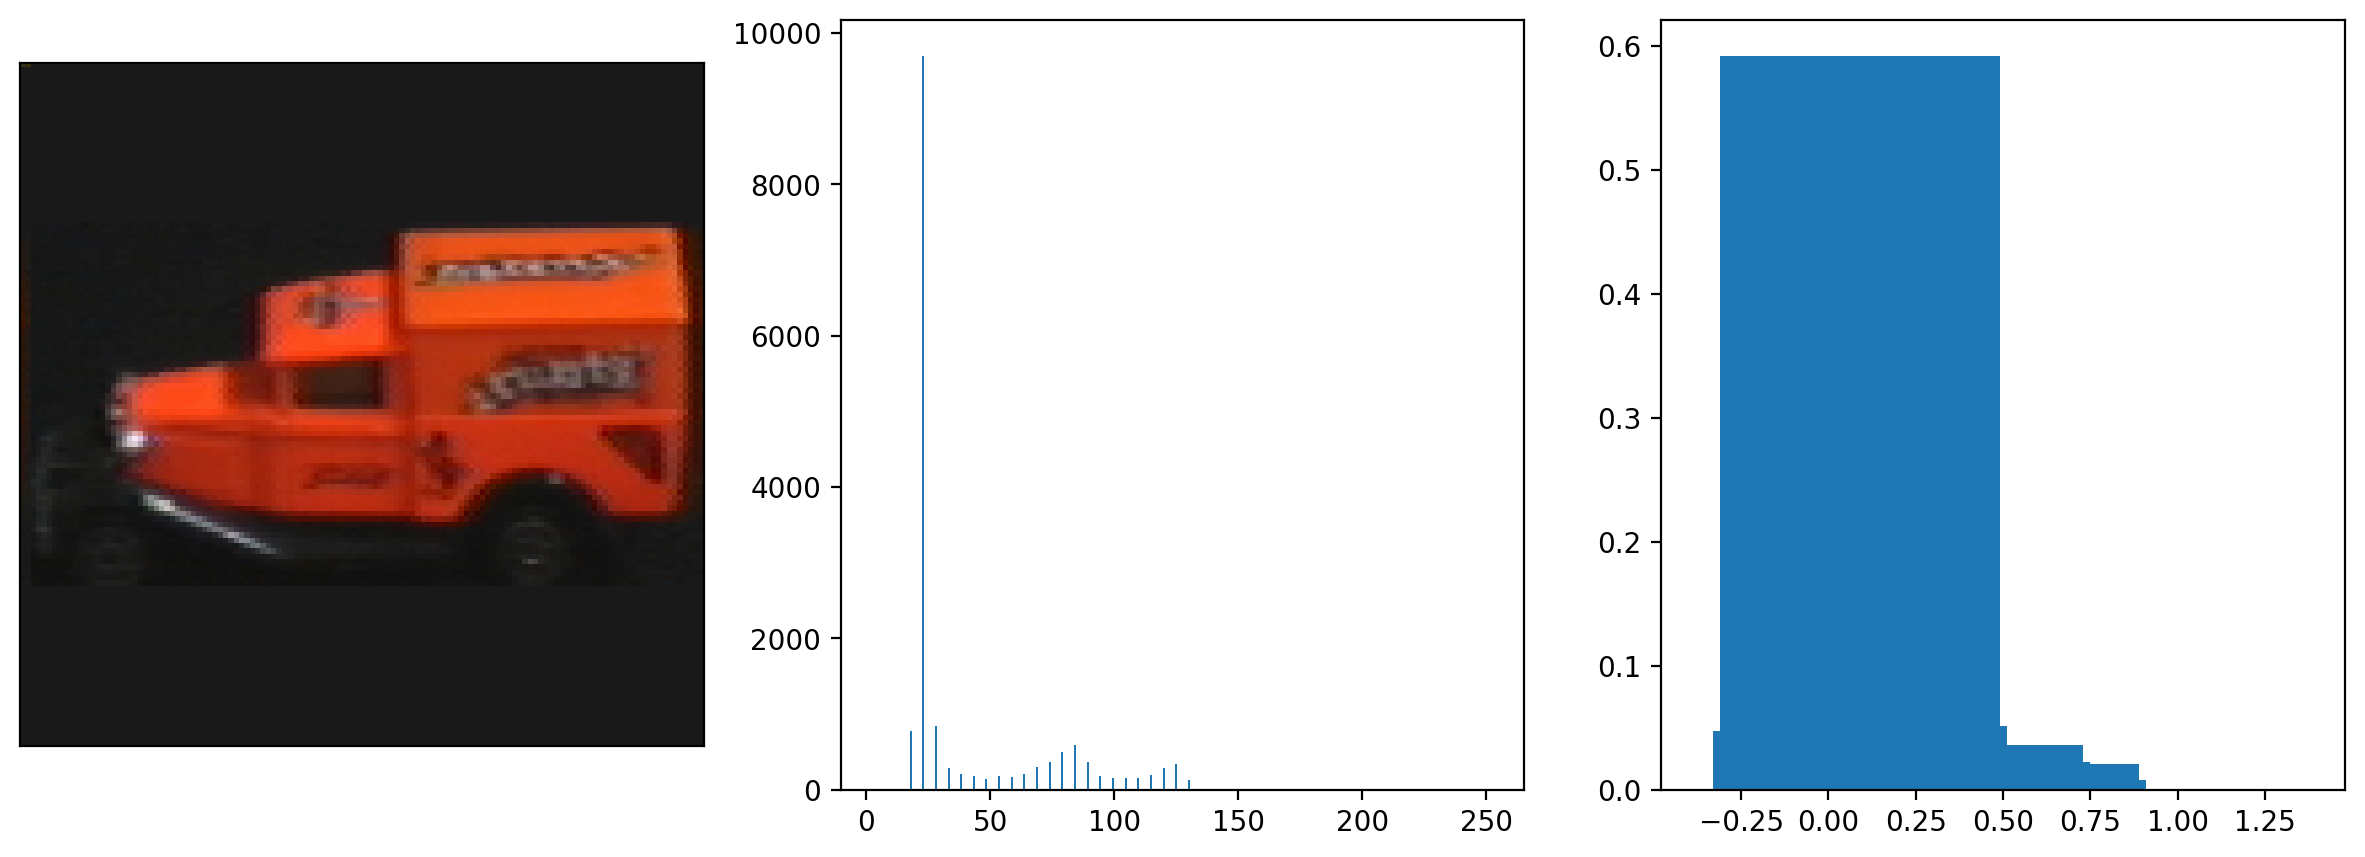

In [7]:
np.set_printoptions(threshold=np.inf)
def normalized_histogram(img_gray, num_bins):
    assert len(img_gray.shape) == 2, 'image dimension mismatch'
    assert img_gray.dtype == 'float', 'incorrect image type'
    
    ######## TODO ##################################
    # Note that a `Normalized` histogram is a histogram where the bins themselves are free in range,
    # but the integral of histogram (sum of all the values in the bins) sums up to 1.

    # define bins and empty histogram
    # bins_unnormalized = np.linspace(start = 0.0, stop = 255.0, num = num_bins+1)

    ## observation : when I use my function to compute the histogram of the unnormalised image, 
    ## the plot is similar to what numpy generates; but the plot changes for the normalised image.
    ## why?
    
    bins = np.linspace(start = 0.0, stop = 1.0, num = num_bins+1)
    hists = np.zeros(num_bins)

    #flatten image and normalize
    flattened_image = img_gray.reshape(-1) / 255.0

    # fill up histogram
    # for pixel_value in flattened_image:
    #    for i in range(num_bins):
    #        if bins[i]<= pixel_value < bins[i+1]:
    #            hists[i] += 1
    #            break

    # vectorize ?
    indices = np.searchsorted(bins, flattened_image, side = 'right') - 1
    #print("bin indices -->", indices)
    indices = np.clip(indices, 0, num_bins-1)
    #print("clipped bin indexes ->", indices)
    hists = np.bincount(indices, minlength = num_bins)[:num_bins]
    #print("histogram -->", hists)
    hists = hists/hists.sum()
    ################################################
    return hists, bins

### The following code is used for evaluation.

img_color = np.array(Image.open('./data/exercise-1/model/obj100__0.png'))
img_gray = rgb2gray(img_color.astype('double'))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

axes[0].imshow(img_color)
axes[0].set_xticks([]);axes[0].set_yticks([]); 

num_bins_gray = 50
hist_gray1, bin_gray1 = hist(img_gray.reshape(img_gray.size), num_bins_gray,(0,255))
axes[1].bar((bin_gray1[0:-1] + bin_gray1[1:])/2, hist_gray1)

hist_gray2, bin_gray2 = normalized_histogram(img_gray, num_bins_gray)
axes[2].bar((bin_gray2[0:-1] + bin_gray2[1:])/2, hist_gray2)
plt.show()

**Q1.2** Implement other histogram types discussed during the tutorial (refer to the introduction slides). Your implementation should extend the code provided in the functions `rgb_hist`, `rg_hist`, and `dxdy_hist`. Make sure that you are using the correct range of pixel values. For “RGB” the pixel intensities are in \[0, 255\], for “rg” the values are normalized to be in \[0, 1\]. For the derivatives histograms the values depend on the σ2 of the Gaussian filter; with σ = 7.0 you can assume that the values are in the range \[−32, 32\].

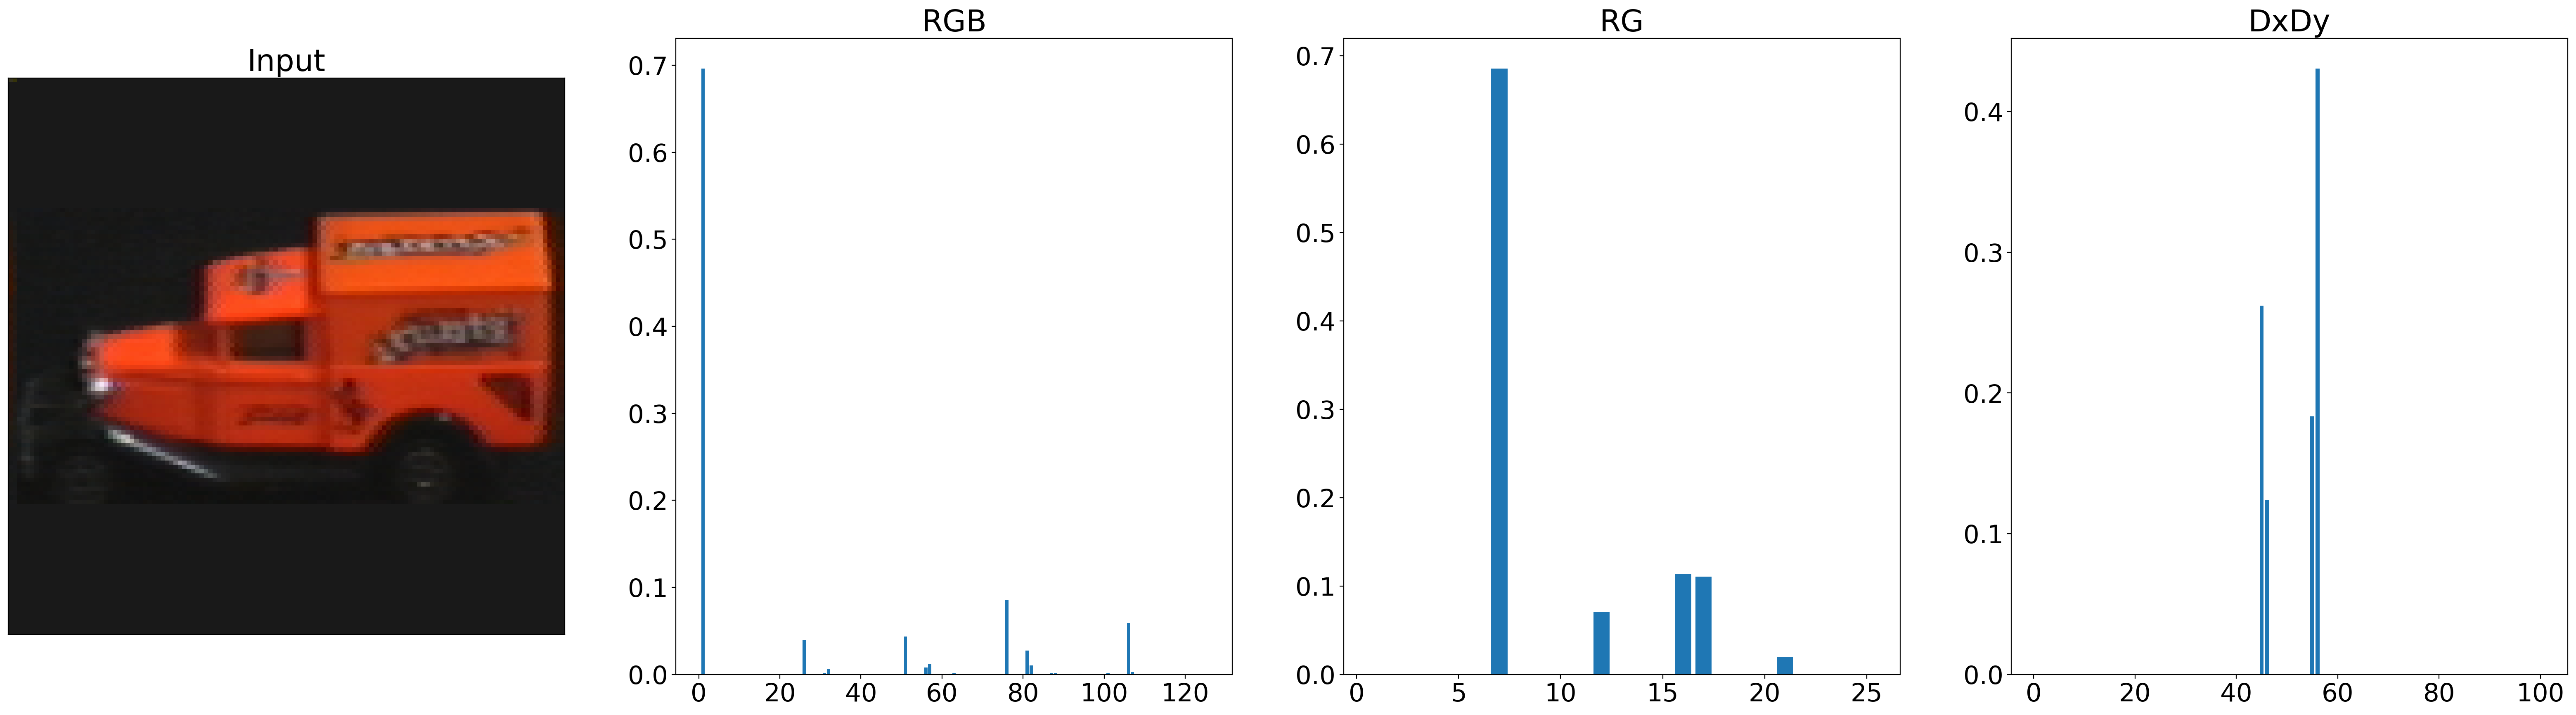

In [16]:
def rgb_hist(img_color, num_bins):
    assert len(img_color.shape) == 3, 'image dimension mismatch'
    assert img_color.dtype == 'float', 'incorrect image type'

    # define a 3D histogram  with "num_bins^3" number of entries
    hists = np.zeros((num_bins, num_bins, num_bins))
    bins = np.linspace(0, 255, num_bins + 1)
    ######## TODO ##################################
	# Fill the 3D histogram
    r = img_color[:, :, 0].reshape(-1)
    g = img_color[:, :, 1].reshape(-1)
    b = img_color[:, :, 2].reshape(-1)

    indices_r = np.searchsorted(bins, r, side = 'right') - 1
    indices_r = np.clip(indices_r, 0, num_bins - 1)

    indices_b = np.searchsorted(bins, b, side = 'right') - 1
    indices_b = np.clip(indices_b, 0, num_bins - 1)

    indices_g = np.searchsorted(bins, g, side = 'right') - 1
    indices_g = np.clip(indices_g, 0, num_bins - 1)
 
    for i in range(len(r)):
        hists[indices_r[i], indices_g[i], indices_b[i]] += 1
    ################################################
    # We flatten the 3D histogram in the end for easier (1D) visualization
    hists = hists.reshape(hists.size)
    hists = hists / hists.sum()
    return hists


def rg_hist(img_color, num_bins):

    """
    compute joint histogram for r/g values
    note that r/g values should be in the range [0, 1];
    histogram should be normalized so that sum of all values equals 1

    img_color - input color image
    num_bins - number of bins used to discretize each dimension, total number of bins in the histogram should be num_bins^2
    """

    assert len(img_color.shape) == 3, 'image dimension mismatch'
    assert img_color.dtype == 'float', 'incorrect image type'
  
    ######## TODO ##################################
	# Fill the 2D r/g histogram with "num_bins^2" number of entries. 
 	# Note that r/g values should be in range [0, 1] and r + g + b = 1.
 
    hists = np.zeros((num_bins, num_bins))
    bins = np.linspace(start = 0.0, stop = 1.0, num = num_bins + 1)
    img_color = img_color / 255.

    #src = img_color.reshape(-1)
    r_src = img_color[:, :, 0]
    g_src = img_color[:, :, 1]
    b_src = img_color[:, :, 2]

    
    pixel_sum = r_src + g_src + b_src
    r = np.where(pixel_sum > 0, r_src / pixel_sum, 0) # prevent division by 0 errors by replacing instances with 0
    g = np.where(pixel_sum > 0, g_src / pixel_sum, 0)

    ones_b = np.ones_like(r)
    b = ones_b - (r + g)
    rb_img = np.stack((r, g, b), axis=2)
    # plt.imshow(rb_img)
    # plt.title("chromaticity")

    r = r.reshape(-1)
    g = g.reshape(-1)
    b = b.reshape(-1)

    indices_r = np.searchsorted(bins, r, side = 'right') - 1
    indices_r = np.clip(indices_r, 0, num_bins - 1)

    indices_g = np.searchsorted(bins, g, side = 'right') - 1
    indices_g = np.clip(indices_g, 0, num_bins - 1)

    for i in range(len(r)):
        hists[indices_r[i], indices_g[i]] += 1

    hists = hists.reshape(hists.size)
    hists = hists / hists.sum()
	# also flatten the final 2D histogram (similar to rgb_hist above).
    ################################################
    return hists



def dxdy_hist(img_gray, num_bins):
    """
    compute joint histogram of Gaussian partial derivatives of the image in x and y direction
    for sigma = 7.0, the range of derivatives is approximately [-32, 32]
    histogram should be normalized so that sum of all values equals 1
    
    img_gray - input grayvalue image
    num_bins - number of bins used to discretize each dimension, total number of bins in the histogram should be num_bins^2
    
    note: you can use the function gaussderiv from the filter exercise.
    """

    ######## TODO ##################################
	# Fill the 2D DxDy histogram with "num_bins^2" number of entries.
	# This is similar to color histograms above just that instead of colors
	# we collect Dx Dy values (i.e edge information)
    hists = np.zeros((num_bins, num_bins))
    bins = np.linspace(start = -32, stop = 32, num = num_bins + 1)

    dx, dy = gaussderiv(img = img_gray, sigma = 7.0)
    dx , dy= dx.reshape(-1), dy.reshape(-1)
    indices_dx = np.searchsorted(bins, dx, 'right') - 1
    indices_dy = np.searchsorted(bins, dy, 'right') - 1

    for i in range(len(dx)):
        hists[indices_dx[i], indices_dy[i]] += 1
	
    hists = hists.reshape(-1)
    hists = hists / hists.sum()
	# also flatten the final 2D histogram (similar to rgb_hist above).
    ################################################
    return hists

### The following code is used for evaluation.
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1, 4, figsize=(40, 10), dpi=200)
axes[0].imshow(img_color)
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[0].set_title('Input')

num_bins_color = 5
hist_rgb1 = rgb_hist(img_color.astype('double'), num_bins_color)
axes[1].bar(np.array(range(1, hist_rgb1.size+1)), hist_rgb1)
axes[1].set_title('RGB')

num_bins_rg = 5
hist_rg = rg_hist(img_color.astype('double'), num_bins_rg)
axes[2].bar(np.array(range(1, hist_rg.size+1)), hist_rg)
axes[2].set_title('RG')

num_bins_dxdy = 10
hist_dxdy = dxdy_hist(img_gray.astype('double'), num_bins_dxdy)
axes[3].bar(np.array(range(1, hist_dxdy.size+1)), hist_dxdy)
axes[3].set_title('DxDy')

plt.show()

**Q1.3** Implement the histogram distance functions discussed during the tutorial (refer to the introdution slides), by filling the missing code in the functions `dist_l2`, `dist_intersect`, and `dist_chi2`.

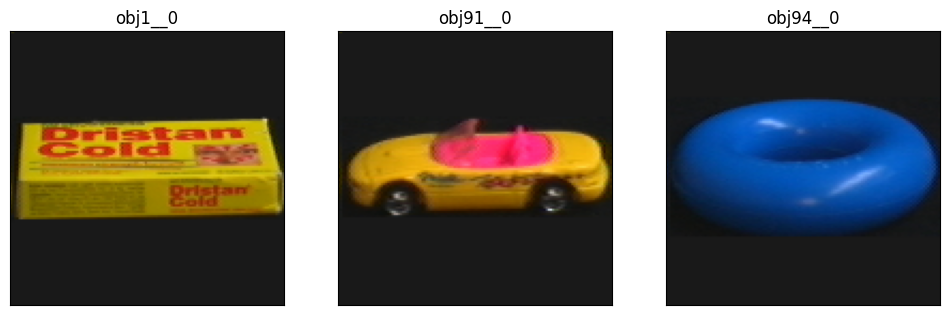

=== Distance Functions:
['l2', 'intersect', 'chi2']
=== Histogram Types:
['grayvalue', 'rgb', 'rg', 'dxdy']
Compare image "obj1__0" to "obj91__0":
[[0.05760147 0.0578308  0.11636563 0.07602957]
 [0.13391113 0.29315186 0.23760986 0.21893311]
 [0.10558725 0.48819844 0.3574684  0.23506075]]
Compare image "obj1__0" to "obj94__0":
[[0.13088992 0.12359277 0.25152823 0.15385402]
 [0.36340332 0.4664917  0.49609375 0.3973999 ]
 [0.53889567 0.8277946  0.86475117 0.54809311]]


In [17]:
def dist_chi2(x,y):
    """ Compute chi2 distance between x and y """
    ####### TODO ###############################   
    dist = None
    # add mask to prevent divide by zero
    denominator = x + y
    mask = denominator > 0
    dist_array = ((x[mask] - y[mask]) ** 2) / (denominator[mask] + 1e-5)
    dist = np.sum(dist_array)
    ############################################   
    return dist
    
def dist_l2(x,y):
    """Compute l2 distance between x and y"""
    ####### TODO ###############################   
    dist = np.sqrt(np.sum((x - y) ** 2))
    ############################################   
    return dist
    
def dist_intersect(x,y):
    """Compute intersection distance between x and y. Return 1 - intersection, so that smaller values also correspond to more similart histograms"""
    ####### TODO ###############################   
    mins = []
    #dist = np.sum(np.min(x , y)) # np.min takes two scalaras and compares them. for now we will use loops
    # for i in range(len(x)):
    #    mins.append(min(x[i], y[i]))
    # dist = 1 - np.sum(mins)

    # np.minimum is the np.min equivalent for array inputs
    dist = 1 - np.sum(np.minimum(x, y))
    ############################################   
    return dist  


def get_dist_by_name(x, y, dist_name):
  dist_methods = {
     'chi2': dist_chi2,
     'intersect': dist_intersect,
     'l2': dist_l2,
  }
  
  assert dist_name in dist_methods, f'Unknown distance: {dist_name}'
  dist_func = dist_methods[dist_name]

  distance = dist_func(x, y)
  return distance


def is_grayvalue_hist(hist_name):
  if hist_name in ['grayvalue', 'dxdy']:
    return True
  elif hist_name in ['rgb', 'rg']:
    return False
  else:
    raise RuntimeError('Unknown histogram type')
    

def get_hist_by_name(img1_gray, num_bins_gray, hist_name):
  hist_methods = {
     'grayvalue': normalized_histogram,
     'rgb': rgb_hist,
     'rg': rg_hist,
     'dxdy': dxdy_hist,
  }
  assert hist_name in hist_methods, f'Unknown histogram type: {hist_name}'
  hist_method = hist_methods[hist_name]

  histogram = hist_method(img1_gray, num_bins_gray)
  return histogram

### The following code is used for evaluation.
image_files1 = ['./data/exercise-1/model/obj1__0.png']
image_files2 = ['./data/exercise-1/model/obj91__0.png',
                './data/exercise-1/model/obj94__0.png']


plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.array(Image.open(image_files1[0])), vmin=0, vmax=255); 
axes[1].imshow(np.array(Image.open(image_files2[0])), vmin=0, vmax=255); 
axes[2].imshow(np.array(Image.open(image_files2[1])), vmin=0, vmax=255); 

# Set The tiles!
axes[0].set_title(image_files1[0].split('/')[-1].removesuffix('.png'))
axes[1].set_title(image_files2[0].split('/')[-1].removesuffix('.png'))
axes[2].set_title(image_files2[1].split('/')[-1].removesuffix('.png'))

# Remove the ticks!
for ax in axes:
   ax.set_xticks([]); ax.set_yticks([])
plt.show()


print('=== Distance Functions:')
distance_types = ['l2', 'intersect', 'chi2']
print(distance_types)

print('=== Histogram Types:')
hist_types = ['grayvalue', 'rgb', 'rg', 'dxdy']
print(hist_types)

num_bins_color = 30
num_bins_gray = 90

for imgidx1 in range(len(image_files1)):
    img1_color = np.array(Image.open(image_files1[imgidx1]))
    img1_gray = rgb2gray(img1_color.astype('double'))
    img1_color = img1_color.astype('double')

    for imgidx2 in range(len(image_files2)):
        img2_color = np.array(Image.open(image_files2[imgidx2]))
        img2_gray = rgb2gray(img2_color.astype('double'))
        img2_color = img2_color.astype('double')

        D = np.zeros( (len(distance_types), len(hist_types)) )

        for didx in range(len(distance_types)):

            for hidx in range(len(hist_types)):

                if is_grayvalue_hist(hist_types[hidx]):
                  hist1 = get_hist_by_name(img1_gray, num_bins_gray, hist_types[hidx])
                  hist2 = get_hist_by_name(img2_gray, num_bins_gray, hist_types[hidx])

                  if len(hist1) == 2 and len(hist1[0]) > 1:
                      hist1 = hist1[0]
                  if len(hist2) == 2 and len(hist2[0]) > 1:
                      hist2 = hist2[0]

                  D[didx,hidx] = get_dist_by_name(hist1, hist2, distance_types[didx])
                
                else:
                  
                  hist1 = get_hist_by_name(img1_color, num_bins_color, hist_types[hidx])
                  hist2 = get_hist_by_name(img2_color, num_bins_color, hist_types[hidx])

                  if len(hist1) == 2 and len(hist1[0]) > 1:
                      hist1 = hist1[0]
                  if len(hist2) == 2 and len(hist2[0]) > 1:
                      hist2 = hist2[0]

                  D[didx, hidx] = get_dist_by_name(hist1, hist2, distance_types[didx])

        print('Compare image "%s" to "%s":'% (
                        image_files1[imgidx1].split('/')[-1].removesuffix('.png'),
                        image_files2[imgidx2].split('/')[-1].removesuffix('.png')
              ))
        print(D)


**Question**: For each of the compared image pairs above, write down under which type of histogram and what type of distance the two images are most and least similar.

**TODO**: Please Write your answer in this cell.

### Question 2: Object Identification (10 points)

**Q2.1** Having implemented different distance functions and image histograms, we can now test how suitable they are for retrieving images in a query-by-example scenario. Implement a function `find_best_match`, which takes a list of model images and a list of query images and for each query image returns the index of the closest model image. The function should take string parameters, which identify the distance function, the histogram function, and the number of histogram bins. See the comments at the beginning of `find_best_match` for more details. Aside from the indices of the best matching images, your implementation should also return a matrix that contains the distances between all pairs of model and query images.

In [18]:
def compute_histograms(image_list, hist_type, hist_isgray, num_bins):
    image_hist = []
    ######## TODO ######################################
	# Similar to the above cell, use the existing function and tools (e.g. rgb2gray or get_hist_by_name)
	# to iterate over image_list and create an array of a per-image histogram.
    for img_path in image_list:
        img = np.array(Image.open(img_path))
        img = img.astype('double')

        if hist_isgray:
            img = rgb2gray(img)
            hist = get_hist_by_name(img, num_bins, hist_type)
        else:
            hist = get_hist_by_name(img, num_bins, hist_type)

        if len(hist) == 2 and len(hist[0]) > 1:
            hist = hist[0]
        image_hist.append(hist)
    ####################################################
    return np.array(image_hist)

def find_best_match(model_images, query_images, dist_type, hist_type, num_bins):

    hist_isgray = is_grayvalue_hist(hist_type)

    model_hists = compute_histograms(model_images, hist_type, hist_isgray, num_bins)
    query_hists = compute_histograms(query_images, hist_type, hist_isgray, num_bins)


    D = np.zeros((len(model_images), len(query_images)))
    best_match = [None] * len(query_images)
    ######## TODO ######################################
    # Fill the D matrix where each element [i, j] reports the distance between i'th model image
    # and j'th query image. 
    # Also create a best_match array of length of query_images, where each
    # i'th element has the closest model_image (just the path).
    
    # Your code here

    for q_idx in range(len(query_images)):
        for m_idx in range(len(model_images)):
            D[m_idx, q_idx] = get_dist_by_name(model_hists[m_idx], query_hists[q_idx], dist_type)

        best_model_idx = np.argmin(D[:, q_idx])
        best_match[q_idx] = model_images[best_model_idx]
    ####################################################
    return best_match, D

### The following code is used for evaluation.
with open('./data/exercise-1/model.txt') as fp:
    model_images = fp.readlines()
model_images = [x.strip() for x in model_images] 

with open('./data/exercise-1/query.txt') as fp:
    query_images = fp.readlines()
query_images = [x.strip() for x in query_images] 

eval_dist_type = 'intersect'
eval_hist_type = 'rg'
eval_num_bins = 30

[best_match, D] = find_best_match(model_images, query_images, eval_dist_type, eval_hist_type, eval_num_bins)

print(best_match)

['./data/exercise-1/model/obj100__0.png', './data/exercise-1/model/obj10__0.png', './data/exercise-1/model/obj1__0.png', './data/exercise-1/model/obj11__0.png', './data/exercise-1/model/obj12__0.png', './data/exercise-1/model/obj13__0.png', './data/exercise-1/model/obj14__0.png', './data/exercise-1/model/obj15__0.png', './data/exercise-1/model/obj16__0.png', './data/exercise-1/model/obj17__0.png', './data/exercise-1/model/obj18__0.png', './data/exercise-1/model/obj19__0.png', './data/exercise-1/model/obj20__0.png', './data/exercise-1/model/obj2__0.png', './data/exercise-1/model/obj21__0.png', './data/exercise-1/model/obj22__0.png', './data/exercise-1/model/obj23__0.png', './data/exercise-1/model/obj24__0.png', './data/exercise-1/model/obj25__0.png', './data/exercise-1/model/obj26__0.png', './data/exercise-1/model/obj27__0.png', './data/exercise-1/model/obj28__0.png', './data/exercise-1/model/obj29__0.png', './data/exercise-1/model/obj30__0.png', './data/exercise-1/model/obj3__0.png', '

**Q2.2** Implement a function `show_neighbors` that takes a list of model images and a list of query images and for each query image visualizes several model images which are the closest to the query image according to the specified distance metric. Use the function `find_best_match` in your implementation. See **Figure 2** for an example output.

**Figure 2: A query image and the model images with color histograms similar to the query image.**

<img src="./data/exercise-1/fig2.png" width="600" align=left>

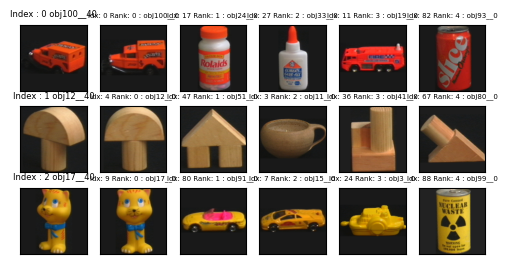

In [19]:
def show_neighbors(model_images, query_images, dist_type, hist_type, num_bins):
    num_nearest = 5  # Show the top-5 neighbors

    q = len(query_images)
    fig, axes = plt.subplots(q, num_nearest + 1, figsize=(num_nearest+1, q))
    ######### TODO ##################################
    # Use the find_best_match and create a figure with most-similar images
    # similar to the figure above. You don't need to exactly match the above figure,
    # just follow the general structure of query image on the left, and nearest training 
    # samples on the right.
    _, D = find_best_match(model_images, query_images, dist_type, hist_type, num_bins)
    if q == 1:
        axes = np.array([axes])
    for q_idx in range(q):
        q_img = np.array(Image.open(query_images[q_idx]))
        axes[q_idx, 0].imshow(q_img, vmin = 0, vmax = 255)
        axes[q_idx, 0].set_title(f"Index : {q_idx} {query_images[q_idx].split('/')[-1].removesuffix('.png')}", fontsize = 6)
        axes[q_idx, 0].set_xticks([]); axes[q_idx, 0].set_yticks([])

        model_indices = np.argsort(D[:, q_idx])[:num_nearest]

        for rank, m_idx in enumerate(model_indices):
            m_img = np.array(Image.open(model_images[m_idx]))
            axes[q_idx, rank+1].imshow(m_img, vmin = 0, vmax = 255)
            axes[q_idx, rank+1].set_title(f"Idx: {m_idx} Rank: {rank} : {model_images[m_idx].split('/')[-1].removesuffix('.png')}", fontsize = 5)
            axes[q_idx, rank+1].set_xticks([]); axes[q_idx, rank+1].set_yticks([])
    

    ################################################
    plt.show()


### The following code is used for evaluation.
query_images_vis = [query_images[i] for i in np.array([0,4,9])]
show_neighbors(model_images, query_images_vis, eval_dist_type, eval_hist_type, eval_num_bins)

### Question 3: Performance Evaluation (10 points)

**Q3.1** Sometimes instead of returning the best match for a query image, we would like to return all the model images with a distance to the query image below a certain threshold. It is, for example, the
case when there are multiple images of the query object among the model images. In order to assess
  the system performance in such scenario, we will use two quality measures: precision and
  recall. Denoting the threshold on the distance between the images by $\tau$ and using the following
  notation:


TP (True Positive) = number of correct matches among the images with distance smaller than $\tau$,
<br>
FP (False Positive) = number of incorrect matches among the images with distance smaller than $\tau$,
<br>
TN (True Negative) = number of incorrect matches among the images with distance larger than $\tau$,
<br>
FN (False Negative) = number of correct matches among the images with distance larger than $\tau$,


precision is given by
\begin{equation}
precision = \frac{TP}{TP + FP},
\end{equation}
and recall is given by
\begin{equation}
recall = \frac{TP}{TP + FN}.
\end{equation}

For an ideal system, there should exist a value of $\tau$ such that
both precision and recall are equal to $1$, which corresponds to
obtaining all the correct images without any false matches. However, in
reality both quantities will be somewhere in the range between $0$ and
$1$ and the goal is to make both of them as high as possible.

Implement a function `plot_rpc` that you have to compute
precision/recall pairs for a range of threshold values and then output
the precision/recall curve (RPC), which gives a good summary of system
performance at different levels of confidence. See **Figure 3** for an example of an RPC curve.

**Q3.2** Plot RPC curves for different histogram types, distances, and number of bins. Submit a summary of your observations as part of your solution.

**Figure 3: Recall/precision curve evaluated on the provided set of model and query images.**

<img src="./data/exercise-1/fig3.png" width="400" align=left>

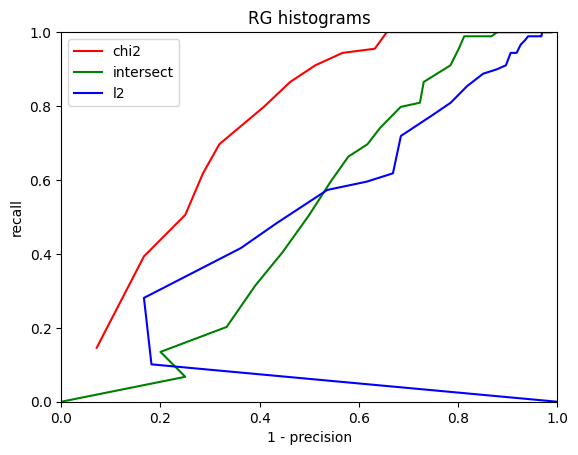

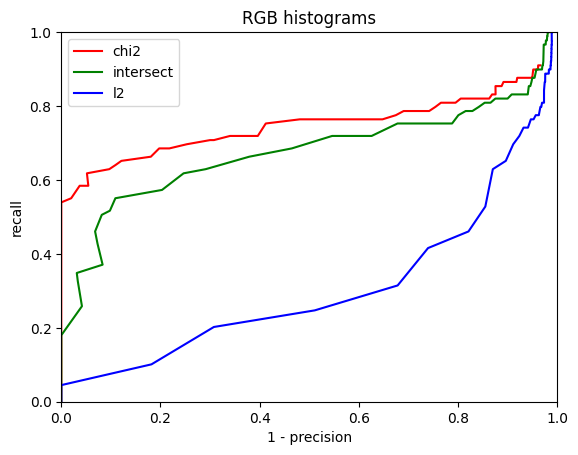

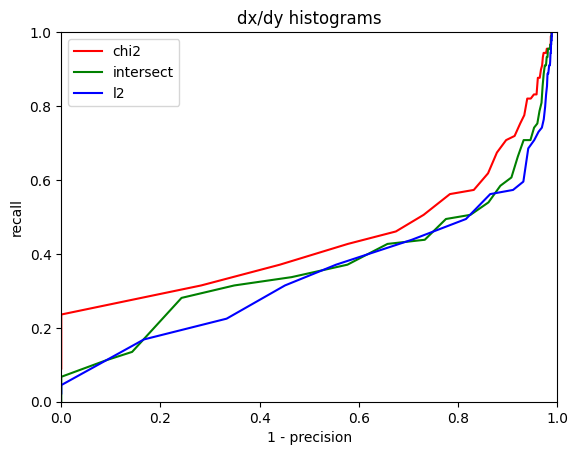

In [20]:
def plot_rpc(D, plot_color):
    recall = []
    precision = []
    thresholds = np.linspace(0.01, 1, 100)
    
    ######## TODO ##############################
    # Compute and plot the recall/precision curve
    # D - square matrix, D(i, j) = distance between model image i, and query image j
    # Note: assume that query and model images are in the same order, i.e. correct answer for i-th query image is the i-th model image
    # Hint: In order to make the evaluation faster, think what threshold values are interesting to be evaluated.
    # Feel free to use numpy operators such as my_array.sum(), my_array.trace() or boolean operators such as 
    # (my_array > my_value) to apply operations at scale, instead of iterating cell-by-cell with loops.
    
    # Your code here
    # Fill the precision and recall values for different thresolds and plot them with plt.plot()
    n = D.shape[0]

    for threshold in thresholds:
        true_positives = np.sum(np.diag(D <= threshold))
        total_positives = np.sum(D <= threshold)
        false_positives = total_positives - true_positives
        false_negatives = n - true_positives

        pr = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 1.0
        r = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        precision.append(pr)
        recall.append(r)
    plt.plot(1 - np.array(precision), recall, plot_color)
        

    ############################################

def compare_dist_rpc(model_images, query_images, dist_types, hist_type, num_bins, plot_colors):
    assert len(plot_colors) == len(dist_types)
    for idx in range(len(dist_types)):#
        [_, D] = find_best_match(model_images, query_images, dist_types[idx], hist_type, num_bins)
        plot_rpc(D, plot_colors[idx])
        plt.axis([0, 1, 0, 1])
        plt.xlabel('1 - precision')
        plt.ylabel('recall')
        plt.legend(dist_types, loc='best')


# The following code is used for evaluation.
with open('./data/exercise-1/model.txt') as fp:
    model_images = fp.readlines()
model_images = [x.strip() for x in model_images] 

with open('./data/exercise-1/query.txt') as fp:
    query_images = fp.readlines()
query_images = [x.strip() for x in query_images] 

eval_num_bins = 20

plt.figure()
compare_dist_rpc(model_images, query_images, ['chi2', 'intersect', 'l2'], 'rg', eval_num_bins, ['r', 'g', 'b'])
plt.title('RG histograms')
plt.show()

plt.figure()
compare_dist_rpc(model_images, query_images, ['chi2', 'intersect', 'l2'], 'rgb', eval_num_bins, ['r', 'g', 'b'])
plt.title('RGB histograms')
plt.show()

plt.figure()
compare_dist_rpc(model_images, query_images, ['chi2', 'intersect', 'l2'], 'dxdy', eval_num_bins, ['r', 'g', 'b'])
plt.title('dx/dy histograms')
plt.show()

**Question**: Please summarize your observations here.

Please write your answer in this cell.

- We can see here that there is often a opposite effect with precision and recall. If recall is high, precision is often low. This makes sense as we go through the different values of the threshold. The best threshold would likely be one close to the middle, that can balance both precision and recall. Though, depending on the task, we may pick a threshold that maximizes one over the other.

- to get the threshold for precision and recall, one could use $F_{\beta}$ score, where $\beta$ weights the precision and recall terms to get a combination that focusses more on precision or recall

Please do not forget that there is also another notebook together with this one. 